# **Chapter 4 – Training Models**

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed as well as Scikit-Learn.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Linear Regression**

Linear Regression model is one of the simplest models there is.

There are two very different ways to train it.

*   Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).


*   Using an iterative optimization approach, called Gradient Descent (GD), that
gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first
method.

Training a model means setting its parameters so that the model best fits the training set.

For this purpose, we first need a measure of how well (or poorly) the model fits the training data.

The most common performance measure of a regression model is the Root Mean Square Error (**RMSE**).

Therefore, to train a Linear Regression model, we need to find the value of θ that minimizes the RMSE.

In practice, it is simpler to minimize the Mean Square Error (**MSE**) than the RMSE, and it leads to the same result (because the value that minimizes a function also minimizes its square root).

### **The Normal Equation**

To find the value of θ that minimizes the cost function, there is a closed-form solution in other words, a mathematical equation that gives the result directly. This is called the **Normal Equation**.

$$ \hat{\theta} = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $$

*   θ is the value of θ that minimizes the cost function.
*   y is the vector of target values containing y (1) to y (m).

It is often the case that a learning algorithm will try to optimize a different function than the performance measure used to evaluate the final model.

This is generally because that function is easier to compute, because it has useful differentiation properties that the performance measure lacks, or because we want to constrain the model during training, as we will see when we discuss regularization.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


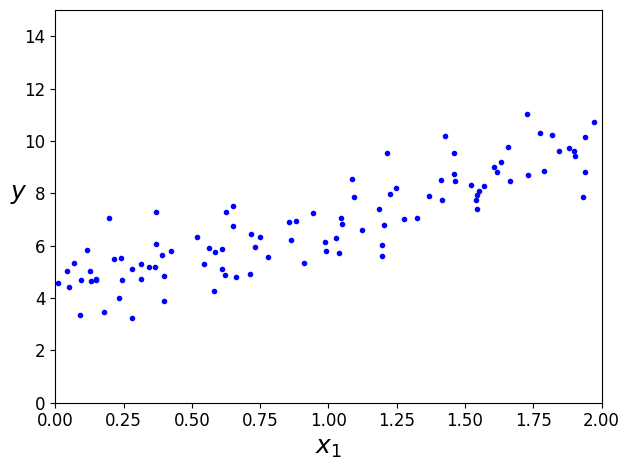

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Now let’s compute θ using the Normal Equation. We will use the inv() function from NumPy’s Linear Algebra module (np.linalg) to compute the inverse of a matrix, and the dot() method for matrix multiplication.

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The actual function that we used to generate the data is y = 4 + 3x1 + Gaussian noise.

Let’s see what the equation found.

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for θ0 = 4 and θ1 = 3 instead of θ0 = 4.215 and θ1 = 2.770. Close enough, but the noise made it impossible to recover the exact parameters of the original function.


Now we can make predictions using θ.

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions.

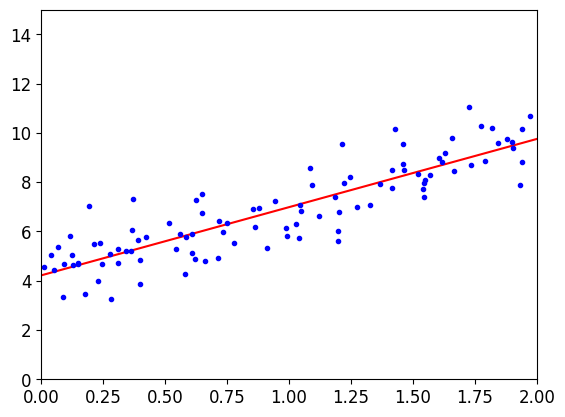

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Saving figure linear_model_predictions_plot


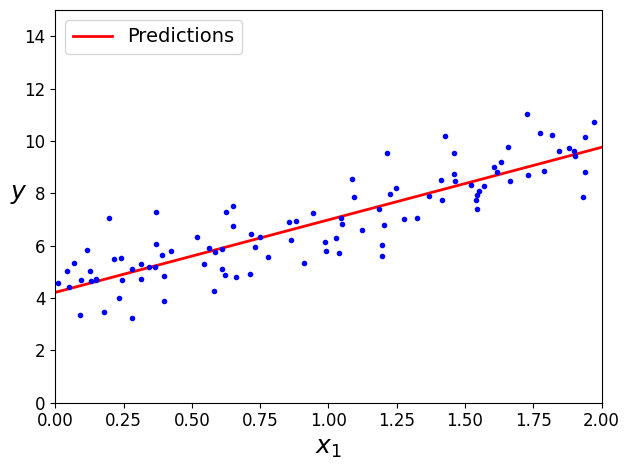

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

Performing **Linear Regression** using Scikit-Learn is quite simple.

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The **LinearRegression** class is based on the **scipy.linalg.lstsq()** function (the name stands for "least squares"), which we could call directly:

In [11]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes θ = $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse).

We can use **np.linalg.pinv()** to compute the pseudoinverse directly:

In [12]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique called Singular Value Decomposition (**SVD**) that can decompose the training set matrix X into the matrix multiplication of three matrices **U Σ V^T** (see numpy.linalg.svd())

Both the Normal Equation and the SVD approach get very slow when the number of features grows large (e.g., 100,000).

On the positive side, both are linear with regards to the number of instances in the training set (they are O(m)), so they handle large training sets efficiently, provided they can fit in memory.

## **Gradient Descent**

Gradient Descent is also an algorithm.

The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

It measures the local gradient of the error function with regards to the parameter vector θ, and it goes in the direction of descending gradient. Once the graient is zero, we have reached a minimum!

Concretely, we start by filling θ with random values (this is called random initialization), and then we improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

An important parameter in Gradient Descent is the size of the steps, determined by the learning rate **hyperparameter**.

If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.

On the other hand, if the learning rate is too high, we might jump across the valley and end up on the other side, possibly even higher up than we were before.

This might make the algorithm diverge, with larger and larger values, failing to find a good solution.

There are two main challenges with Gradient Descent:


*   If the random initialization starts the algorithm on the left, then it will converge to a local minimum, which is not as good as the global minimum.

*   If it starts on the right, then it will take a very long time to cross the plateau, and if we stop too early we will never reach the global minimum.


Fortunately, the **MSE** cost function for a Linear Regression model happens to be a convex function, which means that if we pick any two points on the curve, the line segment joining them never crosses the curve.


This implies that there are no local minima, just one global minimum.

It is also a continuous function with a slope that never changes abruptly.  


These two facts have a great consequence: Gradient Descent is guaranteed to approach arbitrarily close the global minimum (if you wait long enough and if the learning rate is not too high).

When using Gradient Descent, we should ensure that all features have a similar scale (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge.

### **Batch Gradient Descent**

In [13]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
theta

array([[4.21509616],
       [2.77011339]])

In [15]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


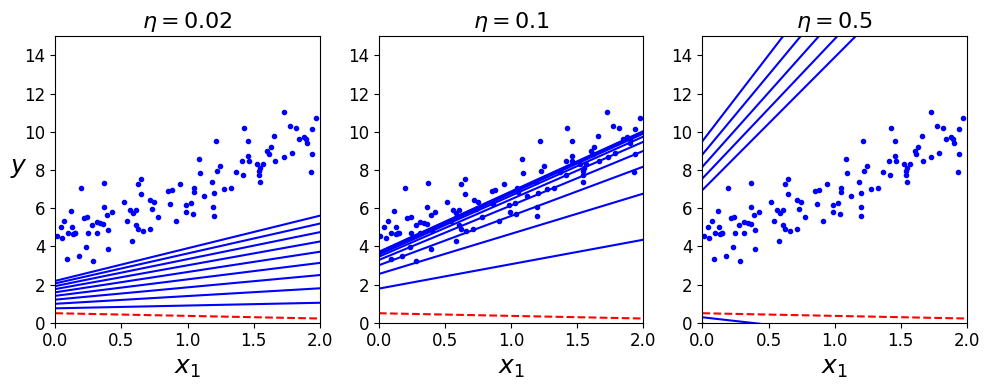

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

### **Stochastic Gradient Descent**

**Stochastic Gradient Descent** just picks a random instance in the training set at every step and computes the gradients based only on that single instance.

Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration (SGD can be implemented as an out-of-core algorithm).



On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average.


Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down.


 So once the algorithm stops, the final parameter values are good, but not optimal.

Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does.

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


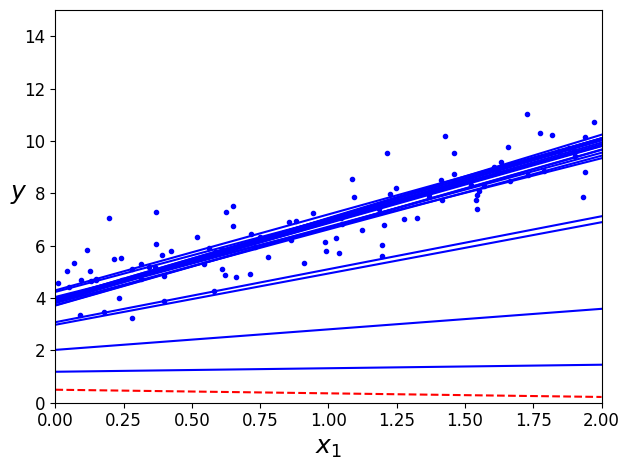

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"        
            plt.plot(X_new, y_predict, style)       
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)               

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                 
plt.ylabel("$y$", rotation=0, fontsize=18)          
plt.axis([0, 2, 0, 15])                             
save_fig("sgd_plot")                               
plt.show()                                         

We iterate by rounds of m iterations; each round is called an **epoch**.


While the Batch Gradient Descent code iterated 1,000 times through the whole training set, this code goes through the training set only 50 times and reaches a fairly good solution.

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

To perform **Linear Regression** using SGD with Scikit-Learn, you can use the SGDRegressor class, which defaults to optimizing the squared error cost function.

The following code runs for maximum 1000 epochs (max_iter=1000) or until the loss drops by less than 1e-3 during one epoch (tol=1e-3), starting with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one), and it does not use any regularization (penalty=None; more details on this shortly).

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### **Mini-batch Gradient Descent**

**Mini-batch Gradient Descent** is quite simple to understand once we know Batch and Stochastic Gradient Descent: at each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Minibatch GD computes the gradients on small random sets of instances called minibatches.

The main advantage of Mini-batch GD over Stochastic GD is that we can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with SGD, especially with fairly large mini-batches.

As a result, Mini-batch GD will end up walking around a bit closer to the minimum than SGD. But, on the other hand, it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike Linear Regression as we saw earlier).

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


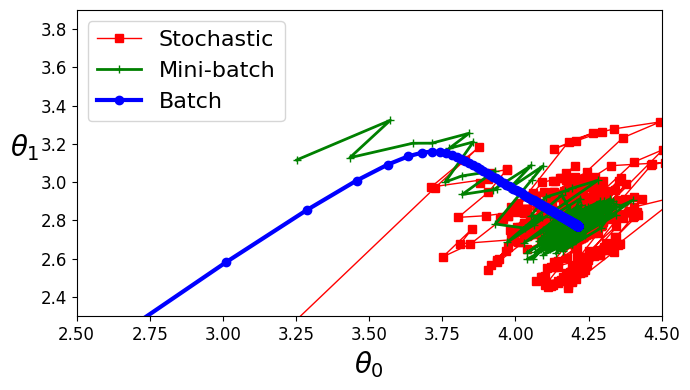

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## **Polynomial Regression**

What if our data is actually more complex than a simple straight line?

Surprisingly, we can actually use a linear model to fit nonlinear data.

A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called **Polynomial Regression**.


Let’s look at an example. First, let’s generate some nonlinear data, based on a simple quadratic equation.

In [27]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [28]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


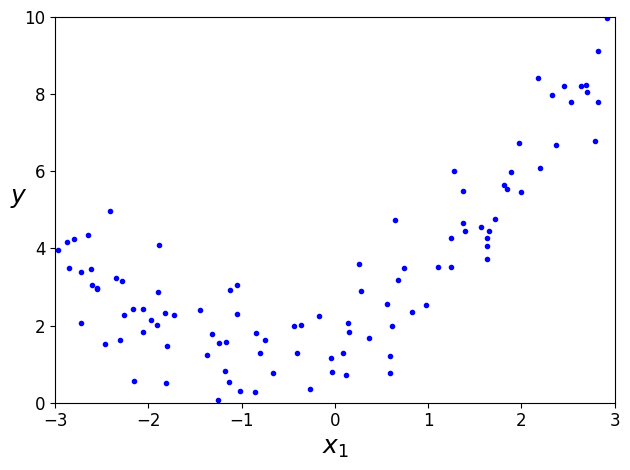

In [29]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly.

So let’s use Scikit-Learn’s PolynomialFeatures class to transform our training data, adding the square (2nd-degree polynomial) of each feature in the training set as new features (in this case there is just one feature).

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

X_poly now contains the original feature of X plus the square of this feature. Now we can fit a LinearRegression model to this extended training data

In [31]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


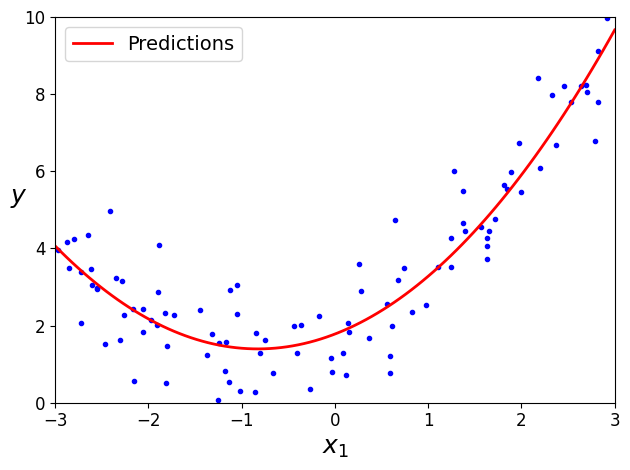

In [33]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

When there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression
model cannot do).

This is made possible by the fact that PolynomialFeatures also
adds all combinations of features up to the given degree.

Saving figure high_degree_polynomials_plot


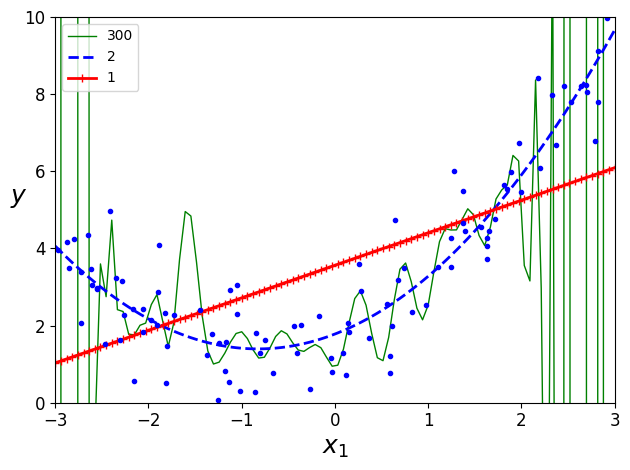

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

## **Learning Curves**

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Let’s look at the learning curves of the plain Linear Regression model (a straight line).

Saving figure underfitting_learning_curves_plot


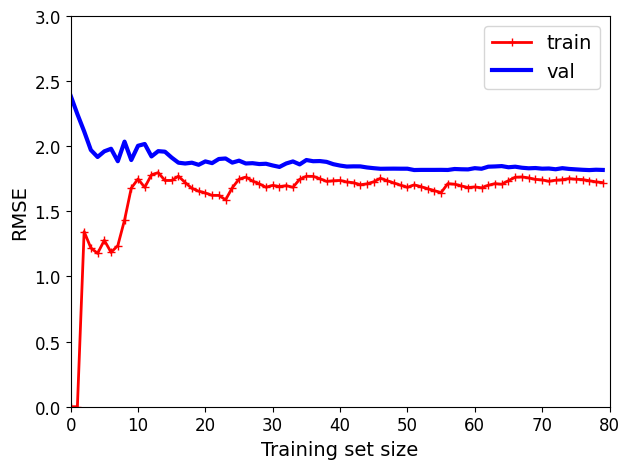

In [36]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

If our model is underfitting the training data, adding more training examples will not help. We need to use a more complex model or come up with better features.

Saving figure learning_curves_plot


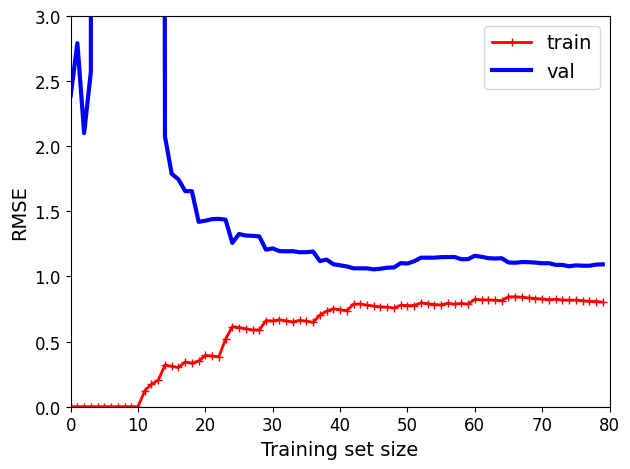

In [37]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           
save_fig("learning_curves_plot")  
plt.show()                    

These learning curves look a bit like the previous ones, but there are two very important differences:

*   The error on the training data is much lower than with the Linear Regression
model.
*   There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

*   Bias
This part of the generalization error is due to wrong assumptions, such as  assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

*   Variance
This part is due to the model’s excessive sensitivity to small variations in the
training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.


*   Irreducible Error
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).


Increasing a model’s complexity will typically increase its variance and reduce its bias.

Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a **tradeoff**.

## **Regularized Linear Models**

A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at Ridge Regression, Lasso Regression, and Elastic Net, which implement three different ways to constrain the weights.

### **Ridge Regression**

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to  is added to the cost function.

This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

In [38]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [39]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [40]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072189]])

Saving figure ridge_regression_plot


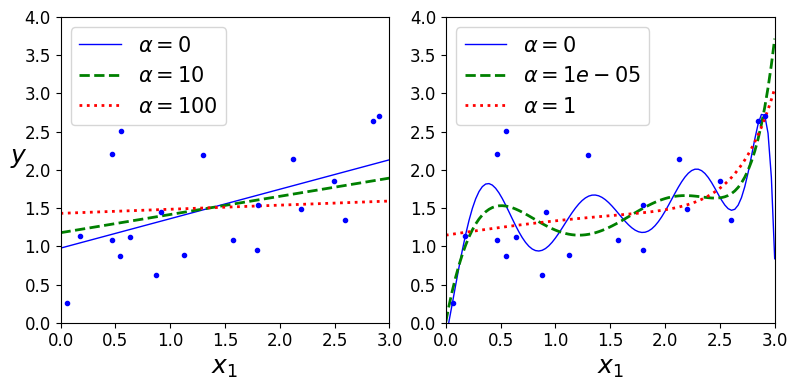

In [41]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

Using Stochastic Gradient Descent.

In [42]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### **Lasso Regression**

Least Absolute Shrinkage and Selection Operator Regression (simply called **Lasso Regression**) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the ℓ1 norm of the weight vector instead of half the square of the ℓ2 norm.

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero).

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


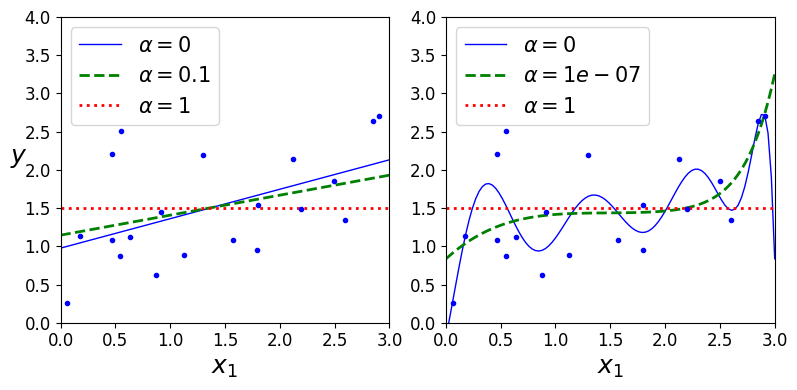

In [43]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [44]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### **Elastic Net**

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and we can control the mix ratio r.

When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression

In [45]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### **Early Stopping**

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called **Early Stopping**.

In [46]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [47]:
from copy import deepcopy
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Build the polynomial + scaler pipeline
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

# Scale train & validation sets
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled   = poly_scaler.transform(X_val)

# Configure SGD to do exactly one epoch per .fit() call
sgd_reg = SGDRegressor(
    max_iter=1,
    tol=None,              # disable early stopping based on tol
    warm_start=True,
    penalty=None,
    shuffle=False,         # keep ordering consistent
    learning_rate="constant",
    eta0=0.0005,
    random_state=42
)

# Loop over epochs, track best on validation set
minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)    # runs exactly one pass
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

print(f"Best validation MSE: {minimum_val_error:.5f} at epoch {best_epoch}")


Best validation MSE: 1.29623 at epoch 237


Creating the graph

Saving figure early_stopping_plot


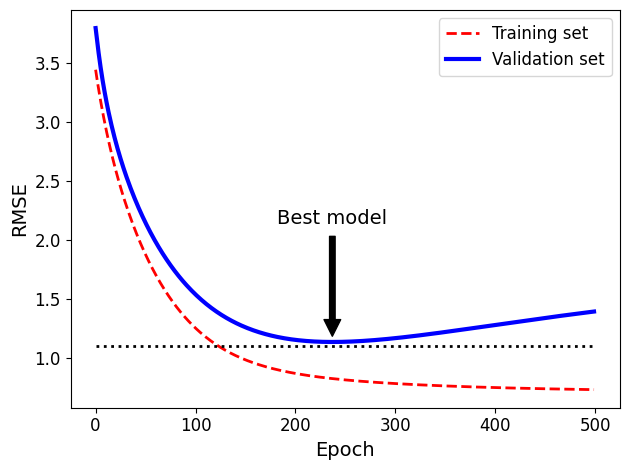

In [48]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# 1) Build & scale with degree-90 polynomial features
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled   = poly_scaler.transform(X_val)

# 2) Configure SGDRegressor for exactly one epoch per fit()
sgd_reg = SGDRegressor(
    max_iter=1,
    tol=None,              # disable tol-based stopping
    warm_start=True,
    penalty=None,
    shuffle=False,         # keep data order consistent across epochs
    learning_rate="constant",
    eta0=0.0005,
    random_state=42
)

# 3) Train for multiple epochs and record errors
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)                   # one more epoch
    train_pred = sgd_reg.predict(X_train_poly_scaled)
    val_pred   = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, train_pred))
    val_errors.append(mean_squared_error(y_val,   val_pred))

# 4) Plot RMSE curves with annotation
best_epoch     = np.argmin(val_errors)
best_val_rmse  = np.sqrt(val_errors[best_epoch])
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.plot(np.sqrt(val_errors),   "b-",  linewidth=3, label="Validation set")
plt.plot([0, n_epochs], [best_val_rmse-0.03]*2, "k:", linewidth=2)
plt.annotate(
    "Best model",
    xy=(best_epoch, best_val_rmse),
    xytext=(best_epoch, best_val_rmse + 1),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=14
)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE",   fontsize=14)
plt.legend(loc="upper right", fontsize=12)
save_fig("early_stopping_plot")
plt.show()

In [49]:
best_epoch, best_model

(237,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, shuffle=False, tol=None, warm_start=True))

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [51]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


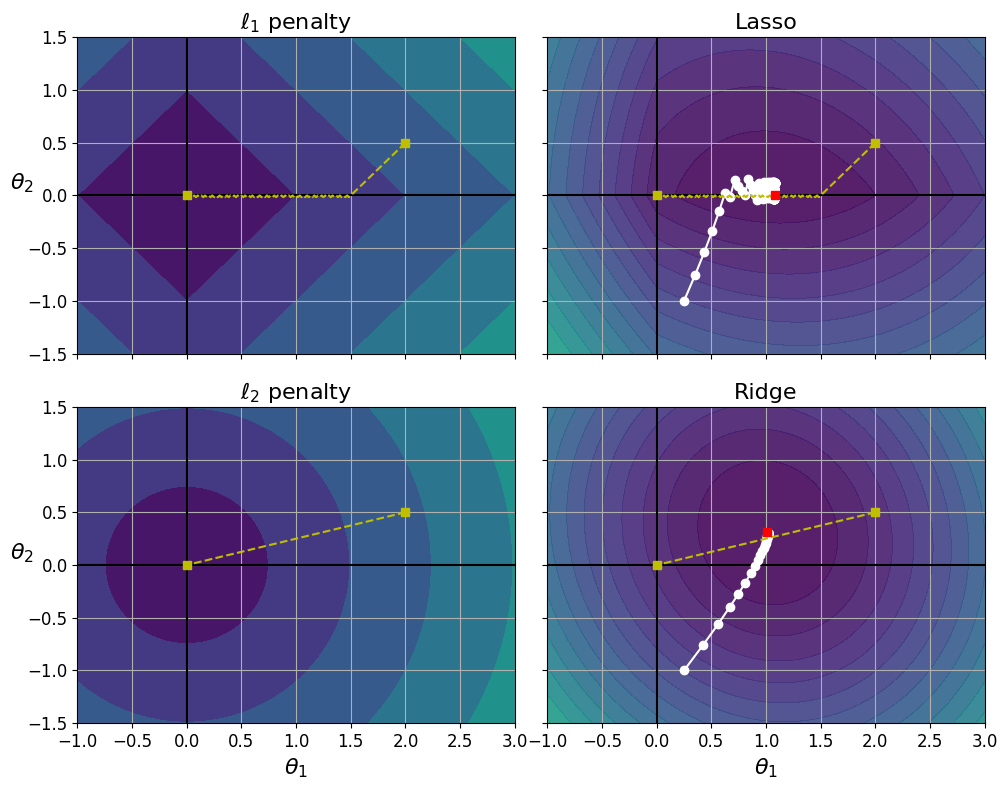

In [52]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2

    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

## **Logistic Regression**

Some regression algorithms can be used for classification as well (and vice versa).

**Logistic Regression** (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?).

If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), or else it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier.

### **Estimating Probabilities**

Like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of this result.

$$ \hat{p} = h_{\theta}(\mathbf{x}) = \sigma(\mathbf{x}^T\theta) $$

The logistic—noted σ(·)—is a sigmoid function (i.e., S-shaped) that outputs a number between 0 and 1.

Saving figure logistic_function_plot


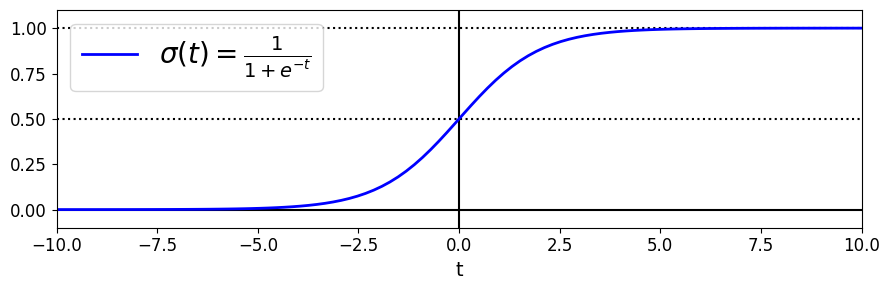

In [53]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

### **Training and Cost Function**

A Logistic Regression model estimates probabilities and makes predictions.


The objective of training is to set the parameter vector θ so that the model estimates high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0).


### **Decision Boundaries**

Let’s try to build a classifier to detect the Iris-Virginica type based only on the petal width feature.

First let’s load the data:

In [54]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [55]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [56]:
import numpy as np
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()

# Features: just the petal width
X = iris["data"][:, 3:].copy()

# Target: 1 for Iris-virginica, else 0
y = (iris["target"] == 2).astype(int)


Now let’s train a Logistic Regression model.

In [57]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

Let’s look at the model’s estimated probabilities for flowers with petal widths varying from 0 to 3 cm.

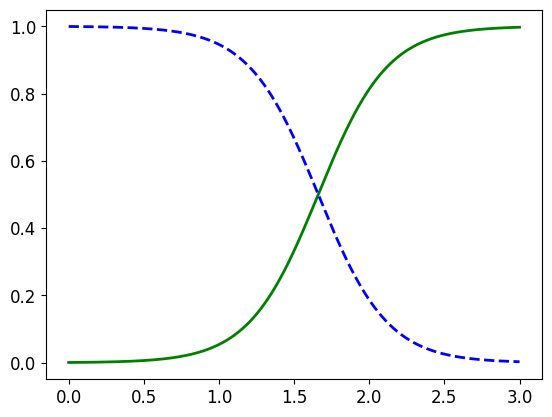

In [58]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

/tmp/ipykernel_35/3400440889.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  decision_boundary = float(X_new[y_proba[:, 1] >= 0.5][0])


Saving figure logistic_regression_plot


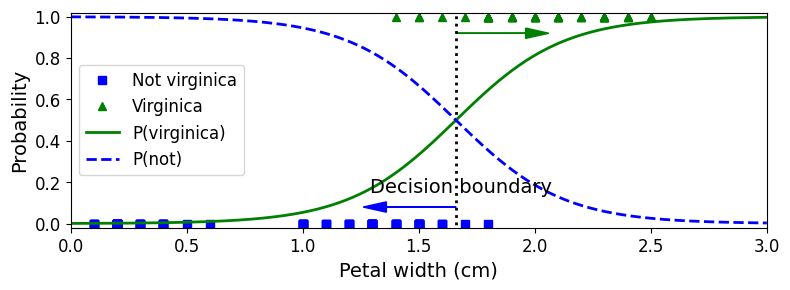

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

# Load data, train a simple logistic regressor
iris = load_iris()
X = iris["data"][:, 3:]                  # petal width
y = (iris["target"] == 2).astype(int)    # 1 if Iris-virginica, else 0
log_reg = LogisticRegression(solver="lbfgs")
log_reg.fit(X, y)

# Compute probabilities and decision boundary
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
# extract as a float, not a 1-element array
decision_boundary = float(X_new[y_proba[:, 1] >= 0.5][0])

# Plot data points, probability curves, and decision lines/arrows
plt.figure(figsize=(8, 3))
plt.plot(X[y == 0], y[y == 0], "bs", label="Not virginica")
plt.plot(X[y == 1], y[y == 1], "g^", label="Virginica")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="P(virginica)")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="P(not)")

# annotate the boundary and arrows
plt.text(decision_boundary + 0.02, 0.15, "Decision boundary",
         fontsize=14, ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0,
          head_width=0.05, head_length=0.1,
          fc="b", ec="b")
plt.arrow(decision_boundary, 0.92, 0.3, 0,
          head_width=0.05, head_length=0.1,
          fc="g", ec="g")

plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability",    fontsize=14)
plt.legend(loc="center left", fontsize=12)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()


The petal width of Iris-Virginica flowers (represented by triangles) ranges from 1.4 cm to 2.5 cm, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm.

Notice that there is a bit of overlap.


Above about 2 cm the classifier is highly confident that the flower is an IrisVirginica (it outputs a high probability to that class), while below 1 cm it is highly confident that it is not an Iris-Virginica (high probability for the “Not Iris-Virginica” class).

In between these extremes, the classifier is unsure.

However, if we ask it to predict the class (using the predict() method rather than the predict_proba() method), it will return whichever class is the most likely.

Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is higher than 1.6 cm, the classifier will predict that the flower is an IrisVirginica, or else it will predict that it is not (even if it is not very confident):

In [60]:
decision_boundary

1.6606606606606606

In [61]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Saving figure logistic_regression_contour_plot


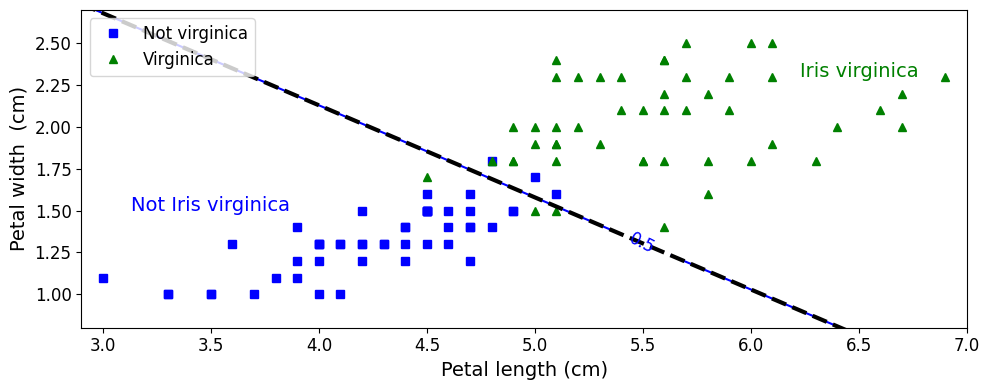

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

# Load Iris data
iris = load_iris()
X = iris["data"][:, (2, 3)]                # petal length, petal width
y = (iris["target"] == 2).astype(int)      # 1 if Iris-virginica, else 0

# Train logistic regression with a very large C (almost no regularization)
log_reg = LogisticRegression(solver="lbfgs", C=1e10, random_state=42)
log_reg.fit(X, y)

# Prepare a grid for plotting decision boundaries
x0s = np.linspace(2.9, 7, 500)
x1s = np.linspace(0.8, 2.7, 200)
x0, x1 = np.meshgrid(x0s, x1s)
X_new = np.c_[x0.ravel(), x1.ravel()]

# Predict class probabilities on the grid
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# Plot data points
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "g^", label="Virginica")

# Contour of probability = 0.5
contour = plt.contour(x0, x1, zz, levels=[0.5], cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)

# Explicit linear decision boundary
left_right = np.array([2.9, 7.0])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
plt.plot(left_right, boundary, "k--", linewidth=3)

# Annotations
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica",     fontsize=14, color="g", ha="center")

# Final touches
plt.xlabel("Petal length (cm)", fontsize=14)
plt.ylabel("Petal width  (cm)", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.legend(loc="upper left", fontsize=12)
save_fig("logistic_regression_contour_plot")
plt.show()


The above graph shows the same dataset but this time displaying two features: petal width and length.

Once trained, the Logistic Regression classifier can estimate the probability that a new flower is an Iris-Virginica based on these two features. The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary.

Note that it is a linear boundary.18 Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90%
(top right). All the flowers beyond the top-right line have an over 90% chance of being Iris-Virginica according to the model.

### **Softmax Regression**

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called **Softmax Regression**, or **Multinomial Logistic Regression**.

The Softmax Regression classifier predicts only one class at a time (i.e., it is multiclass, not multioutput) so it should be used only with mutually exclusive classes such as different types of plants.

We cannot use it to recognize multiple people in one picture.

Let’s use Softmax Regression to classify the iris flowers into all three classes.

ScikitLearn’s LogisticRegression uses one-versus-all by default when we train it on more than two classes, but we can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression instead.

We must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver. It also applies ℓ2 regularization by default, which we can control using the hyperparameter C.

In [63]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Saving figure softmax_regression_contour_plot


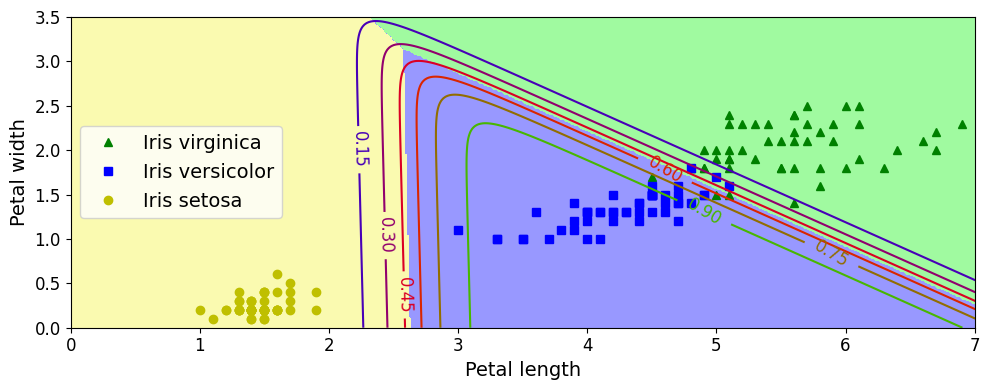

In [64]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

So the next time we find an iris with 5 cm long and 2 cm wide petals, we can ask your model to tell you what type of iris it is, and it will answer Iris-Virginica (class 2) with 94.2% probability (or Iris-Versicolor with 5.8% probability).

In [65]:
softmax_reg.predict([[5, 2]])

array([2])

In [66]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## **Exercises**

### **Question 1**

What Linear Regression training algorithm can you use if you have a training set
with millions of features?

When tackling Linear Regression with a training set boasting millions of features, the traditional Normal Equation quickly becomes unfeasible due to the immense computational cost of matrix inversion.

Instead, we'll want to pivot to **Gradient Descent-based algorithms**, which are far more scalable for such high-dimensional problems.

The top contenders here are:

1.  **Stochastic Gradient Descent (SGD):** This method is incredibly efficient for massive datasets. It updates the model parameters by calculating the gradient using just one random training instance at a time. This makes each step lightning-fast, allowing rapid progress, even if the optimization path appears a bit "noisy." It's excellent when memory is a constraint and speed is paramount.

2.  **Mini-batch Gradient Descent:** This approach strikes a great balance. Instead of one instance, it uses a small, random "mini-batch" of the training data to compute the gradient for each update. This reduces the noise compared to pure SGD, leading to a more stable convergence. Yet, it remains significantly faster and less memory-intensive than processing the entire dataset at once (like Batch Gradient Descent would). The mini-batch size is a tunable hyperparameter.

While **Batch Gradient Descent** theoretically exists, its requirement to process the entire dataset for each update makes it impractical and too slow for datasets with millions of features.

Therefore, for Linear Regression with vast feature sets, SGD and Mini-batch Gradient Descent are your most effective and practical choices. They efficiently handle large-scale data without requiring the entire dataset in memory, ensuring timely model training.

### **Question 2**

Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?

It's a great question because feature scaling is a really common and important preprocessing step in machine learning!

When features in your training set have vastly different scales (e.g., one feature ranges from 0 to 1, while another ranges from 1,000 to 1,000,000), several algorithms can indeed suffer quite a bit. Here's a breakdown of which ones and why, along with what you can do:

### Algorithms That Suffer and How:

1.  **Gradient Descent-based Algorithms (e.g., Linear Regression, Logistic Regression, Neural Networks, Support Vector Machines):**
    * **How they suffer:** These algorithms work by iteratively updating parameters based on the gradient of the cost function. If features are on different scales, the cost function will resemble a very elongated, narrow ellipse or a steep valley. Gradient Descent will struggle to find the minimum efficiently because it will take tiny steps along the narrow dimensions to avoid overshooting, but large, zig-zagging steps along the wider dimensions. This leads to much slower convergence, requiring many more iterations to reach the optimal solution. In extreme cases, it might even oscillate around the minimum without converging effectively.
    * **Why:** The gradient is much larger for features with larger scales, dominating the updates, even if those features aren't necessarily more important.

2.  **K-Nearest Neighbors (KNN) and K-Means Clustering:**
    * **How they suffer:** These algorithms rely heavily on distance calculations (like Euclidean distance) between data points. If features have different scales, the feature with the largest range will disproportionately influence the distance metric, effectively "dominating" the distance calculation. A small change in a large-scaled feature could appear more significant than a large, meaningful change in a small-scaled feature. This can lead to incorrect nearest neighbor assignments or cluster formations.
    * **Why:** The distance is calculated directly using the raw feature values, so features with larger magnitudes have a larger contribution to the overall distance.

3.  **Support Vector Machines (SVMs), especially with RBF or Polynomial Kernels:**
    * **How they suffer:** Similar to KNN, SVMs, particularly those using kernel tricks like Radial Basis Function (RBF) or polynomial kernels, are sensitive to feature scales. The kernel function measures similarity between data points, and if features are not scaled, one feature's large values can unfairly dominate this similarity measure. This can lead to the SVM performing poorly, struggling to find an optimal separating hyperplane.
    * **Why:** The kernel calculations are based on distances or dot products of the feature vectors, making them susceptible to features with larger magnitudes.

4.  **Principal Component Analysis (PCA):**
    * **How it suffers:** PCA aims to find directions (principal components) of maximum variance in the data. If features have vastly different scales, the components will tend to be dominated by the features with the largest variance (and thus largest scale), regardless of their actual importance. This can lead to less meaningful principal components that don't effectively capture the true underlying structure of the data.
    * **Why:** PCA is inherently variance-maximizing. If one feature has a variance orders of magnitude larger than others due to its scale, PCA will naturally prioritize that feature.

### What You Can Do About It:

The solution is to **scale your features**. This involves transforming the feature values so they fall within a similar range. The two most common methods are:

1.  **Min-Max Scaling (Normalization):**
    * **What it does:** Rescales features to a fixed range, usually between 0 and 1.
    * **Formula:** $x_{new} = \frac{x - x_{min}}{x_{max} - x_{min}}$
    * **When to use:** Good for algorithms that are sensitive to the absolute scale of values or where you want features to be within a specific range. However, it's sensitive to outliers, as they will compress the range of the majority of the data.

2.  **Standardization (Z-score Normalization):**
    * **What it does:** Rescales features to have a mean of 0 and a standard deviation of 1.
    * **Formula:** $x_{new} = \frac{x - \mu}{\sigma}$ (where $\mu$ is the mean and $\sigma$ is the standard deviation)
    * **When to use:** Generally preferred for algorithms that assume normally distributed data (like many linear models) or those sensitive to the variance of features (like PCA, SVMs, Gradient Descent). It's less affected by outliers than Min-Max scaling because it doesn't bound values to a specific range.

**Key Best Practices:**

* **Fit on Training Data, Transform on All Data:** Crucially, calculate the scaling parameters (min/max or mean/std dev) *only* from your training data. Then, use these *same* calculated parameters to transform your training data, validation data, and test data. Never fit the scaler on the validation or test set to avoid data leakage.
* **Apply Before Training:** Feature scaling is a preprocessing step that should be done *before* feeding the data into your machine learning algorithm.

By applying appropriate feature scaling, you can significantly improve the performance, convergence speed, and overall effectiveness of these sensitive machine learning algorithms.

### **Question 3**

Can Gradient Descent get stuck in a local minimum when training a Logistic
Regression model?


No, Gradient Descent will **not** get stuck in a local minimum when training a Logistic Regression model.

The cost function used for Logistic Regression (the log loss or cross-entropy loss) is a **convex function**. A convex function has only one global minimum and no other local minima.

Since there's only one minimum to find, Gradient Descent, regardless of its starting point, will always converge to that single global minimum. It might take longer or follow a different path depending on the learning rate and initialization, but it will always reach the optimal solution for Logistic Regression.

### **Question 4**

Do all Gradient Descent algorithms lead to the same model provided you let
them run long enough?

Not necessarily. While all Gradient Descent algorithms aim to find the minimum of a cost function, whether they lead to the *exact same model* depends on a few critical factors:

1.  **Convex vs. Non-Convex Cost Functions:**
    * **Convex:** If the cost function is convex (like in Linear or Logistic Regression), it has only one global minimum. In this case, given enough time and an appropriate learning rate, all Gradient Descent variants (Batch, Mini-batch, SGD) will converge to the **same global minimum**, meaning they'll ultimately find the same optimal model parameters.
    * **Non-Convex:** For non-convex cost functions (common in Neural Networks), there are often multiple local minima and saddle points. Here, different Gradient Descent algorithms, or even the same algorithm with different initializations or hyperparameters, might converge to **different local minima**. This means they could result in different models with varying performance.

2.  **Learning Rate and Hyperparameters:** Even for convex functions, a very large learning rate might cause divergence. For non-convex functions, the learning rate, momentum, and other optimizer-specific hyperparameters significantly influence which minimum is found.

3.  **Stochasticity (SGD and Mini-batch GD):** SGD and Mini-batch GD introduce randomness because they use only a subset of the data for each update. This inherent randomness means they might not converge to the *exact* same point as Batch Gradient Descent (which uses the whole dataset). However, for convex problems, they will converge to a very close approximation of the global minimum. For non-convex problems, this randomness can sometimes help escape shallow local minima.

In summary, for convex problems, they generally converge to the same model. For non-convex problems, they often don't, and the outcome can vary.

### **Question 5**

Suppose you use Batch Gradient Descent and you plot the validation error at
every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?


If we're using Batch Gradient Descent and the validation error consistently goes up with every epoch, it's a clear sign of **overfitting**.

Here's why and how to fix it:

**What's Likely Going On (Overfitting):**

Our model is learning the training data too well, including its noise and specific patterns, but it's failing to generalize to new, unseen data (your validation set). As training continues, the model memorizes the training examples, and its performance on data it hasn't seen before starts to degrade.

**How to Fix This:**

1.  **Early Stopping:** This is often the simplest and most effective solution. Stop training as soon as the validation error reaches its minimum and starts to increase. The model saved at that point is your best generalized model.

2.  **Regularization:** Add a penalty to the cost function to discourage the model from becoming too complex and overfitting. Common types include:
    * **L1 Regularization (Lasso):** Encourages sparse weights (some weights become exactly zero), effectively performing feature selection.
    * **L2 Regularization (Ridge):** Shrinks weights towards zero but doesn't make them exactly zero.
    * **Elastic Net:** A combination of L1 and L2 regularization.

3.  **Get More Training Data:** More data helps the model learn more robust patterns and reduces the likelihood of overfitting to a small, specific training set.

4.  **Reduce Model Complexity:** If your model is too complex for the task or the amount of data, simplify it. For example, in a Polynomial Regression, reduce the polynomial degree. In Neural Networks, reduce the number of layers or neurons.

5.  **Feature Selection/Engineering:** Remove irrelevant or redundant features that might be contributing to noise, or create new features that better represent the underlying relationships.

6.  **Reduce Learning Rate (less common for consistent increase):** While a very high learning rate can cause the cost function to diverge (jump around wildly), if it's consistently *increasing* on validation and training is still progressing, it points more strongly to overfitting than divergence. However, if the training error also consistently goes up, then a high learning rate could be the primary issue.

The first two (Early Stopping and Regularization) are typically your immediate go-to solutions for consistent validation error increase due to overfitting.

### **Question 6**

Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

No, it's generally **not a good idea to stop Mini-batch Gradient Descent immediately** when the validation error goes up for the very first time.

Here's why and what we should consider:

Mini-batch Gradient Descent, and especially Stochastic Gradient Descent (SGD), inherently has a lot more **noise** in its training process compared to Batch Gradient Descent. Because it updates the model using only a small subset of the data at each step, the calculated gradient is an approximation, and the cost function (and thus validation error) can fluctuate quite a bit from one iteration or epoch to the next.

A temporary "blip" or slight increase in validation error might just be due to this noise, and the model might continue to improve in subsequent steps.

**What to do instead:**

1.  **Monitor for Consistency:** Don't react to a single increase. Instead, observe if the validation error consistently increases over several consecutive epochs (e.g., 5-10 or more, depending on your dataset size and learning rate). This indicates a genuine trend of overfitting.

2.  **Patience Parameter (for Early Stopping):** Implement early stopping with a "patience" parameter. This means you continue training for a specified number of additional epochs even after the validation error starts to rise. If the validation error doesn't drop again within that "patience" window, *then* you stop and revert to the model parameters from the epoch where the validation error was lowest.

3.  **Averaging:** Sometimes, you might average the validation error over a few recent epochs to get a more stable signal, rather than reacting to instantaneous fluctuations.

In essence, the stochastic nature of Mini-batch GD means its progress isn't as smooth as Batch GD. We need to account for this inherent variability before deciding to halt training.

### **Question 7**

Which Gradient Descent algorithm (among those we discussed) will reach the
vicinity of the optimal solution the fastest? Which will actually converge? How
can you make the others converge as well?

1.  **Reaching the Vicinity of the Optimal Solution the Fastest:**
    * **Stochastic Gradient Descent (SGD)** will typically reach the vicinity of the optimal solution the fastest. Because it updates the model parameters using only one instance at a time, each step is incredibly quick. This allows it to make rapid initial progress and get close to the minimum much quicker than the others, especially on large datasets.

2.  **Which Will Actually Converge (to the exact optimum on convex problems):**
    * **Batch Gradient Descent** will actually converge to the exact global minimum (for convex cost functions) if you let it run long enough and use an appropriate learning rate. It takes precise steps because it computes the true gradient using the entire dataset.

3.  **How to Make the Others Converge As Well:**
    * **Mini-batch Gradient Descent and Stochastic Gradient Descent (SGD):** To make these algorithms truly converge (or at least get very, very close) to the global minimum on convex problems, you need to implement a **learning schedule**. A learning schedule gradually **reduces the learning rate over time**.
        * **Why this works:** Initially, a higher learning rate allows for fast progress. As the algorithm approaches the minimum, reducing the learning rate helps it take smaller, more precise steps, preventing it from oscillating wildly around the minimum due to the inherent noise. Without a decaying learning rate, SGD and Mini-batch GD will typically oscillate around the minimum, never truly settling on the exact optimal point.

### **Question 8**

Suppose you are using Polynomial Regression. You plot the learning curves and
you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

Okay, when we're using Polynomial Regression and we see a **large gap between the training error and the validation error** on your learning curves, with the training error being very low and the validation error being significantly higher, it's a classic sign of **overfitting**.

Here's what's happening and three ways to solve it:

**What's Happening (Overfitting):**
Our Polynomial Regression model is too complex for the underlying data. It has learned the training data (including its noise and specific quirks) almost perfectly, resulting in a very low training error. However, this complexity means it doesn't generalize well to new, unseen data (your validation set), leading to a high validation error. The model is essentially "memorizing" the training examples rather than learning the general patterns.

**Three Ways to Solve This:**

1.  **Reduce the Polynomial Degree:** This is the most direct approach for Polynomial Regression. If we're using a degree of, say, 10, try reducing it to 2, 3, or 4. A lower degree will create a simpler model, forcing it to learn more general trends rather than fitting every tiny fluctuation in the training data, thus reducing the gap and improving generalization.

2.  **Regularization (e.g., Ridge or Lasso Regression):** Add a penalty term to your model's cost function to discourage large weights. This effectively "constrains" the model's complexity.
    * **Ridge Regression (L2):** Adds a penalty proportional to the square of the magnitude of the coefficients.
    * **Lasso Regression (L1):** Adds a penalty proportional to the absolute value of the coefficients, which can also lead to sparse models (some coefficients becoming zero, effectively performing feature selection).
    Regularization forces the model to simplify and rely less on any single feature, which helps close the gap between training and validation error.

3.  **Get More Training Data:** If possible, increasing the size of our training dataset can be very effective. With more diverse examples, the model has a harder time simply memorizing the noise and is forced to learn more robust, generalizable patterns. This makes it more difficult for the model to overfit to specific instances and helps the validation error come down closer to the training error.

### **Question 9**

Suppose you are using Ridge Regression and you notice that the training error
and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?

When we're using Ridge Regression and notice that the **training error and validation error are almost equal and both are fairly high**, this is a classic indicator that our model suffers from **high bias** (also known as underfitting).

Here's why and what to do about the regularization hyperparameter $\alpha$:

**What's Happening (High Bias/Underfitting):**

* **Training error is high:** The model isn't even performing well on the data it was trained on. This means it's too simplistic to capture the underlying patterns in the data.
* **Validation error is also high and similar to training error:** This confirms the model isn't learning enough. It's not generalizing poorly; it just fundamentally isn't complex enough to fit the data.
* **Ridge Regression and $\alpha$:** Ridge Regression introduces a penalty (controlled by $\alpha$) that shrinks the model's weights. A high $\alpha$ means a stronger penalty, leading to simpler models.

**Should we increase $\alpha$ or reduce it?**

We should **reduce the regularization hyperparameter $\alpha$**.

* **Why reduce $\alpha$**: A high $\alpha$ is currently forcing our model to be too simple (high bias). By reducing $\alpha$, we are lessening the penalty on the weights, allowing the model to become more complex. This increased complexity will enable the model to better fit the training data and, hopefully, the validation data too, bringing both errors down.

### **Question 10**

Why would you want to use:

*   Ridge Regression instead of plain Linear Regression (i.e., without any regularization)?
*   Lasso instead of Ridge Regression?
*   Elastic Net instead of Lasso?

### Why use Ridge Regression instead of plain Linear Regression?

We'd opt for **Ridge Regression over plain Linear Regression** primarily to **prevent overfitting** and to handle **multicollinearity**.

* **Overfitting:** Plain Linear Regression can easily overfit, especially with many features or noisy data, leading to a high variance model that performs poorly on new data. Ridge Regression adds an L2 penalty ($\alpha \sum w_i^2$) to the cost function, which shrinks the model's weights towards zero. This "regularization" makes the model simpler and more robust, reducing its variance and improving its generalization ability.
* **Multicollinearity:** When features are highly correlated, plain Linear Regression can have very unstable and large coefficient estimates. Ridge Regression's penalty helps stabilize these coefficients by shrinking them, leading to more reliable predictions.

### Why use Lasso instead of Ridge Regression?

We'd choose **Lasso Regression over Ridge Regression** when we suspect that **only a few features are truly important** or if you need **feature selection**.

* **Feature Selection:** Lasso adds an L1 penalty ($\alpha \sum |w_i|$). Unlike Ridge, which only shrinks weights towards zero, Lasso can push some weights *exactly* to zero. This effectively performs automatic feature selection, making the model simpler and easier to interpret by identifying and excluding less relevant features.
* **Sparsity:** This ability to drive coefficients to zero results in a "sparse" model. If we have many features and believe only a subset are truly influential, Lasso is a powerful tool to identify that subset.

### Why use Elastic Net instead of Lasso?

We'd pick **Elastic Net instead of Lasso** for a robust combination of regularization and when dealing with **highly correlated features where Lasso might struggle**.

* **Combines Best of Both Worlds:** Elastic Net combines both the L1 (Lasso) and L2 (Ridge) penalties. This means it inherits Lasso's ability to perform feature selection (making some weights zero) and Ridge's ability to handle highly correlated features gracefully.
* **Handling Correlated Features (Lasso's weakness):** When we have groups of highly correlated features, Lasso tends to arbitrarily pick only *one* feature from the group and completely ignore the others. Ridge, on the other hand, would shrink the weights of all correlated features proportionally. Elastic Net, by including the L2 penalty, will tend to select *all* features from a correlated group rather than just one, providing a more stable and often better performing model in such scenarios. This makes it a generally safer default choice than Lasso when in doubt.

### **Question 11**

Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime.
Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

For classifying pictures as outdoor/indoor AND daytime/nighttime, we should implement **two separate Logistic Regression classifiers**.

Here's why:

* **Independent Tasks:** The "outdoor/indoor" classification is completely independent of the "daytime/nighttime" classification. A picture can be indoor *and* daytime, indoor *and* nighttime, outdoor *and* daytime, or outdoor *and* nighttime. These are not mutually exclusive categories.

* **Softmax Regression for Mutually Exclusive Classes:** Softmax Regression is designed for multi-class classification where the classes are **mutually exclusive** (e.g., classifying an animal as *either* a cat, *or* a dog, *or* a bird – it can't be both simultaneously). Softmax outputs probabilities that sum to 1 across all classes, forcing a choice among them.

* **Logistic Regression for Binary, Independent Tasks:** Since our tasks are binary (two choices for each: outdoor/indoor, daytime/nighttime) and independent, two Logistic Regression classifiers are appropriate. Each classifier would output a probability for its respective binary outcome (e.g., one outputs P(outdoor) and the other outputs P(daytime)).

Using a single Softmax classifier would incorrectly assume that "outdoor," "indoor," "daytime," and "nighttime" are four mutually exclusive categories, which they are not in this scenario. For example, you couldn't easily represent "outdoor and daytime" as a single Softmax output.

### **Question 12**

Implement Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn).

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [67]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [68]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [69]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [70]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [71]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:

In [72]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [73]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [74]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [75]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [76]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [77]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


The Softmax model is trained. Let's look at the model parameters:

In [78]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Let's make predictions for the validation set and check the accuracy score:

In [79]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [80]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.503640075014894
1500 0.4946891059460321
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.48929905984511984
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better?

Let's find out:

In [81]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [82]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109127
1500 0.5355752782580262
2000 0.5331959249285544
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327977 early stopping!


In [83]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Now let's plot the model's predictions on the whole dataset:

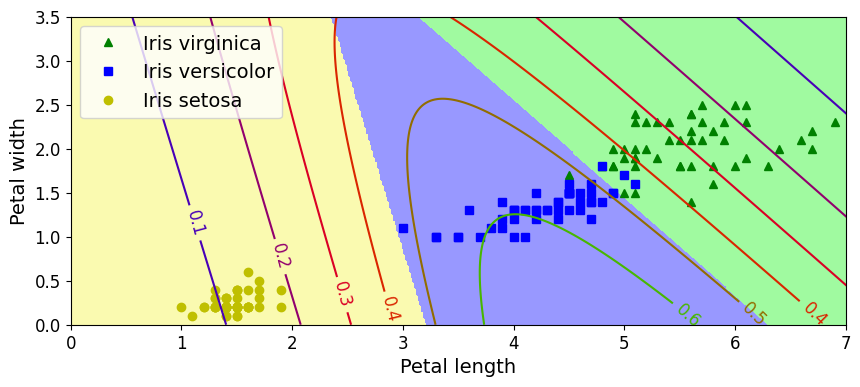

In [84]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [85]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333